In [18]:
from stellargraph.core import StellarGraph
from stellargraph.core.utils import normalized_laplacian, normalize_adj
from stellargraph.mapper.adjacency_power_generators import AdjacencyPowerGenerator
from stellargraph.layer import GCN, GraphLogLikelihood
from stellargraph.layer.watch_your_step import WatchYourStep

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model
from sklearn import preprocessing, feature_extraction, model_selection

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

## Loading in the data

In [8]:
data_dir = os.path.expanduser("~/data/cora")
os.listdir(data_dir)
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

## Creating the model

First, we create a StellarGraph object from our NetworkX graph. From this, we create an `AdjacencyPowerGenerator` which loops through the rows of the first `num_powers` of the adjacency matrix.

In [9]:
G = StellarGraph(Gnx)
generator = AdjacencyPowerGenerator(G, num_powers=5)

Next, we use the `WatchYourStep` class to create trainable node embeddings and expected random walks.

In [11]:
wys = WatchYourStep(generator, 60, 64)
x_in, x_out = wys.build()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


We use the graph log likelihood as our loss function, however because of the input and output shapes of this loss function it is more convenient to define the loss function as a layer and use an identity loss for the keras model.

In [12]:
loss = GraphLogLikelihood()(x_out + x_in)

model = Model(inputs=x_in, outputs=loss)
model.compile(loss=lambda x, y: y, optimizer='adam')

In [33]:
from tensorflow.keras import backend as K

# Lambda(K.concatenate((x_out[0], x_out[1]), axis=1))
from tensorflow.keras.layers import Concatenate
Concatenate(axis=1)([x_out[0], x_out[1]])

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 5416) dtype=float32>

## Training

We now create a training generator and fit our model.

In [20]:
batch_size = 10
train_gen = generator.flow(batch_size=batch_size)

history = model.fit(
    train_gen, epochs=20, 
    verbose=1,
    steps_per_epoch=int(len(G.nodes()) // batch_size))

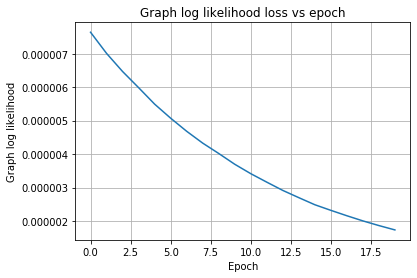

In [25]:
plt.title("Graph log likelihood loss vs epoch")
plt.xlabel("Epoch")
plt.ylabel("Graph log likelihood")
plt.grid()
plt.plot(history.history['loss'])
plt.show()

## Visualizing Embeddings

Now we use TSNE to visualize the embeddings.